In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from skopt.space import Integer, Real, Categorical
from skopt import BayesSearchCV
from scipy.stats import uniform, loguniform

In [2]:
df = pd.read_csv('data/engineered_cmv&unpop_data')

In [3]:
df.drop(columns = ['Unnamed: 0'], inplace = True)

***Exploratory Data Analysis***

In [4]:
non_numerics = df.select_dtypes(exclude = np.number).columns.tolist()

In [5]:
excluded_ints = ['num_comments', 'post_score', 'post_subreddit']

In [6]:
ordered_sums = df.select_dtypes(include = np.dtype('int64')).drop(columns = excluded_ints).sum(numeric_only = True).sort_values(ascending = False).index

In [7]:
sentiments = ['neg_sentiment', 'pos_sentiment', 'neu_sentiment', 'comp_sentiment']

In [8]:
drops = excluded_ints.copy()
drops.extend(sentiments)

In [9]:
reindexer = []
reindexer.extend(non_numerics)
reindexer.extend(sentiments)
reindexer.extend(excluded_ints)
reindexer.extend(ordered_sums)

In [10]:
df = df.reindex(reindexer, axis=1)

- Additional cleaning after engineering.

In [11]:
df.isna().sum().sort_values(ascending = False).head()

post_text          13
post_title          4
author_username     0
specifically        0
driving             0
dtype: int64

In [12]:
df.dropna(inplace = True)

- Check for artifacts with oddly high means.

In [13]:
means = df.mean(axis=0)

In [14]:
odd_ones = {key: val for key, val in means.to_dict().items() if val > 1}

- Nothing out of the ordinary here.

In [15]:
odd_ones

{'num_comments': 44.39810996563574,
 'post_score': 27.2819587628866,
 'people': 1.4501718213058419}

- Drop additional stopwords that were not covered by CountVectorizer.

In [16]:
mentions = df[df.columns.tolist()].sum()

In [17]:
list(mentions.keys())[11:36]

['people',
 'like',
 'just',
 'don',
 'wa',
 'think',
 'ha',
 'make',
 'thing',
 'time',
 'want',
 'way',
 'woman',
 'say',
 'know',
 'life',
 'good',
 'really',
 'right',
 'believe',
 'feel',
 'person',
 've',
 'need',
 'year']

In [18]:
df.drop(columns = ['http', 'cmv', 've', 'ha', 'wa'], inplace = True) 

- Most frequently used words, least frequently used words.

In [19]:
mentions = df[df.columns.tolist()].sum()

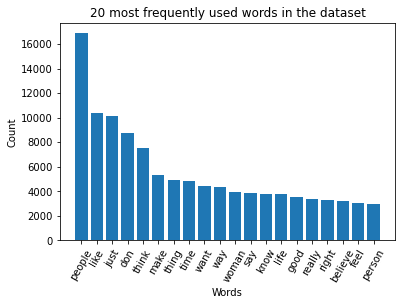

In [20]:
keys = list(mentions.to_dict().keys())
values = list(mentions.to_dict().values())

plt.bar(keys[11:31], values[11:31])
plt.xticks(rotation = 60)
plt.title("20 most frequently used words in the dataset")
plt.ylabel("Count")
plt.xlabel("Words")
plt.savefig('images/frequent_words_all.png', bbox_inches = 'tight', pad_inches = .3)

- Many posts appear to talk about (perhaps unsurprisingly) opinions, given the frequency of people, like, don't, say, feel, know, and think.

In [21]:
y_vars = excluded_ints.copy()

In [22]:
y_vars.remove('post_subreddit')

In [23]:
x_vars = sentiments

- Outlier and distributions check.

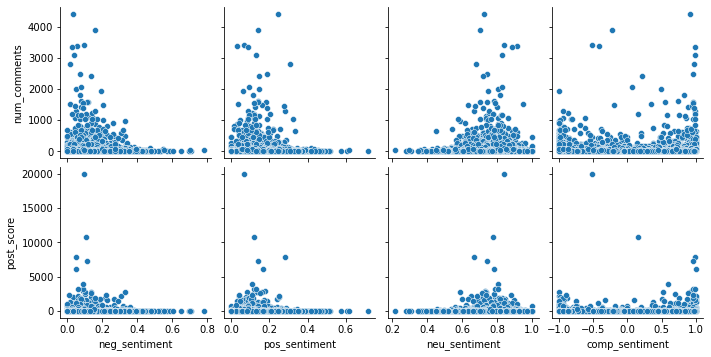

In [24]:
sns.pairplot(df, x_vars = x_vars, y_vars = y_vars)
plt.show()

- No need to remove these outliers, as post_score and num_comments both just indicate additional text data that will not be used in this analysis.
- Posts in these subreddits that receive upvotes or comments appear to be clustered around low negative and positive sentiments and high neutral sentiment.

In [25]:
df[df['post_subreddit'] == 1][x_vars].describe()

,neg_sentiment,pos_sentiment,neu_sentiment,comp_sentiment
count,5083.000000,5083.000000,5083.000000,5083.000000
mean,0.109749,0.120235,0.770015,0.095624
std,0.069411,0.056279,0.078972,0.836227
min,0.000000,0.000000,0.350000,-0.999900
25%,0.060000,0.081000,0.721000,-0.901650
50%,0.098000,0.114000,0.775000,0.377400
75%,0.149000,0.153000,0.823000,0.941600
max,0.650000,0.574000,1.000000,0.999900


In [26]:
df[df['post_subreddit'] == 0][x_vars].describe()

,neg_sentiment,pos_sentiment,neu_sentiment,comp_sentiment
count,6557.000000,6557.000000,6557.000000,6557.000000
mean,0.127368,0.134477,0.738159,0.028524
std,0.087528,0.079834,0.096993,0.759375
min,0.000000,0.000000,0.217000,-0.999700
25%,0.065000,0.081000,0.678000,-0.795300
50%,0.114000,0.126000,0.742000,0.072600
75%,0.176000,0.179000,0.803000,0.826100
max,0.783000,0.718000,1.000000,0.999800


In [27]:
#credit to: https://datavizpyr.com/overlapping-histograms-with-matplotlib-in-python/
def sentiment_grams(sentiment_label, sentiment_proper):
    plt.hist(df[df['post_subreddit'] == 0][sentiment_label], bins=100, alpha=0.5, label="Unpopular Opinion")
    plt.hist(df[df['post_subreddit'] == 1][sentiment_label], bins=100, alpha=0.5, label="Change my View")

    plt.xlabel(f"Post {sentiment_proper.lower()} sentiment score", size=14)
    plt.ylabel("Count", size=14)
    plt.title(f"{sentiment_proper} sentiment of posts in r/unpopularopinion and r/changemyview")
    plt.legend(loc='upper right')

    plt.savefig(f'images/{sentiment_label}_comparison.png', bbox_inches = 'tight', pad_inches = .3)
    plt.show()

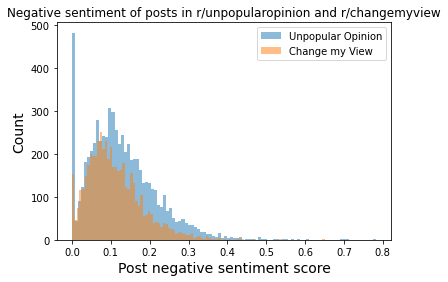

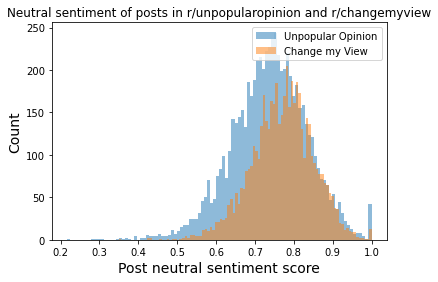

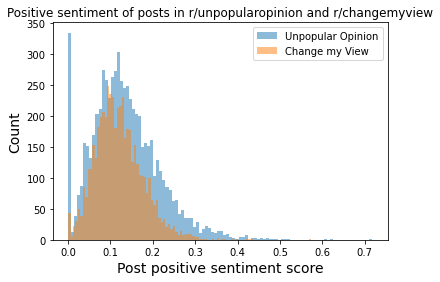

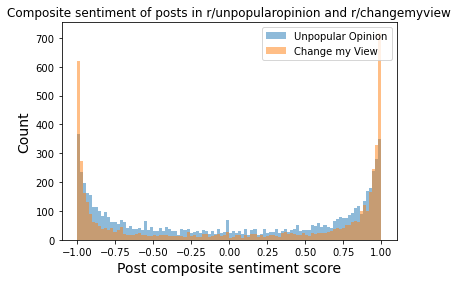

In [28]:
sentiment_grams('neg_sentiment', 'Negative')
sentiment_grams('neu_sentiment', 'Neutral')
sentiment_grams('pos_sentiment', 'Positive')
sentiment_grams('comp_sentiment', 'Composite')

- Unpopular opinion is slightly more negative in terms of language on average, but shows a higher spread across all sentiments (std).

- Create a ratio of all word counts between the two subreddits.

In [29]:
dissimilarities = df[df['post_subreddit'] == 1].drop(columns = drops).sum(numeric_only = True) / df[df['post_subreddit'] == 0].drop(columns = drops).sum(numeric_only = True)

In [30]:
dissimilarities.sort_values(ascending = True, inplace = True)

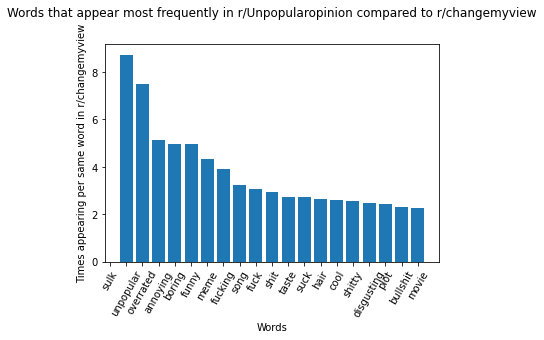

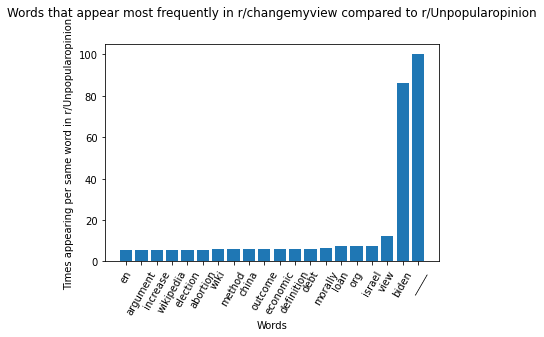

In [31]:
keys = list((1/dissimilarities).to_dict().keys())
values = list((1/dissimilarities).to_dict().values())

plt.bar(keys[:20], values[:20])
plt.xticks(rotation = 60)
plt.title("Words that appear most frequently in r/Unpopularopinion compared to r/changemyview", y= 1.1)
plt.ylabel("Times appearing per same word in r/changemyview")
plt.xlabel("Words")
plt.savefig('images/word_ratio_unpop.png', bbox_inches = 'tight', pad_inches = .3)
plt.show()

keys = list(dissimilarities.to_dict().keys())
values = list(dissimilarities.to_dict().values())

plt.bar(keys[len(dissimilarities) - 20:], [val if val <= 100 else 100 for val in values[len(dissimilarities) - 20:]])
plt.xticks(rotation = 60)
plt.title("Words that appear most frequently in r/changemyview compared to r/Unpopularopinion", y= 1.1)
plt.ylabel("Times appearing per same word in r/Unpopularopinion")
plt.xlabel("Words")
plt.savefig('images/word_ratio_cmv.png', bbox_inches = 'tight', pad_inches = .3)

- These charts show interesting differences between the two subreddits:
   - Negatively opinionated words such as 'overrated', 'annoying', 'boring', 'trash', 'shit, 'suck, and 'shitty' all appear at least three times more often in Unpopular opinion that in change my view. 
   - 'Song', 'meme', and 'anime' appear more frequently in Unpopular opinion than in change my view. Taken with the above point, it is likely that posts in Unpopular opinion are frequently about the quality of popular works of media.
   - Reddit specific language such as 'wiki', 'report', 'downvotes', 'submitting, and 'moderator' appear more frequently in change my view.
   - Hello appears much more frequently in change my view, similar to a formal email or other message.
   - Similarly, polite language such as 'concern', 'remind', and 'firstly' appear more over 20 times more frequently in change my view than in Unpopular opinion.
   - Biden appears much more frequently in change my view than in unpopular opinion, though surprisingly 'Trump' does not appear on this list. This data is scraped over a long enough period that I would have expected it.

In [32]:
dissimilarities['trump'], dissimilarities['politics']

(2.7676767676767677, 2.580357142857143)

- Trump does appear more often in change my view than in unpopular opinion. Politics does as well, and the three together seem to indicate that political opinions are voice more often in change my view than in unpopular opinion as a whole. I am curious why Biden appears 90 times more often in cmv and Trump only appears 3 times more often.

In [33]:
df['trump'].sum(), df['biden'].sum()

(1119, 174)

- It appears that Biden's appearance so often in cmv compared to unpop may be due to low sample size - one tenth of the appearances that Trump makes.

In [34]:
df['_____'].sum()

1040

In [37]:
list(df[df['post_text'].str.contains('_____')]['post_text'].to_dict().values())[:3]

['democrat always say that if obama would have ever done ______ then republican would have impeached him 27 time it s true because conservative would pin him down on the issue and won t forget about it when the next episode of bachelorette come out whether it s fair or not',
 'hollywood vote on the academy award nomination routinely the star are paid le based on skin color and being female this wa evidenced by the leaked email routinely lead role go to white men and young white woman that is evidenced by a quick review of film released in 2015 2014 etc hollywood often back the most progressive candidate during election yet a quick review of hollywood s collective action reveals what would be the most repressive fortune 500 company or political party in the usa i am merely noting the king is wearing no clothes shame on hollywood _____',
 'recently i ve encountered mutliple political theory mostly on the internet speaking of a globalist elite and cultural marxism because of the support f

In [38]:
df.drop(columns = '_____', inplace = True)

- Save edited csv.

In [39]:
df.to_csv('data/explored_cmv&unpop_data')

- On to part 5 ->